In [11]:
'''Functions for drawing contours of Dirichlet distributions.'''

# Author: Thomas Boggs

from __future__ import division, print_function

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

_corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
_AREA = 0.5 * 1 * 0.75**0.5
_triangle = tri.Triangulation(_corners[:, 0], _corners[:, 1])

# For each corner of the triangle, the pair of other corners
_pairs = [_corners[np.roll(range(3), -i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))

def xy2bc(xy, tol=1.e-4):
    '''Converts 2D Cartesian coordinates to barycentric.

    Arguments:

        `xy`: A length-2 sequence containing the x and y value.
    '''
    coords = np.array([tri_area(xy, p) for p in _pairs]) / _AREA
    return np.clip(coords, tol, 1.0 - tol)

class Dirichlet(object):
    def __init__(self, alpha):
        '''Creates Dirichlet distribution with parameter `alpha`.'''
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                     np.multiply.reduce([gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * np.multiply.reduce([xx ** (aa - 1)
                                                for (xx, aa)in zip(x, self._alpha)])
    def sample(self, N):
        '''Generates a random sample of size `N`.'''
        return np.random.dirichlet(self._alpha, N)

def draw_pdf_contours(dist, border=True, nlevels=20, subdiv=8, **kwargs):
    '''Draws pdf contours over an equilateral triangle (2-simplex).

    Arguments:

        `dist`: A distribution instance with a `pdf` method.

        `border` (bool): If True, the simplex border is drawn.

        `nlevels` (int): Number of contours to draw.

        `subdiv` (int): Number of recursive mesh subdivisions to create.

        kwargs: Keyword args passed on to `plt.triplot`.
    '''
    from matplotlib import ticker, cm
    import math

    refiner = tri.UniformTriRefiner(_triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, cmap='Blues', **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.triplot(_triangle, linewidth=1)

def plot_points(X, barycentric=True, border=True, **kwargs):
    '''Plots a set of points in the simplex.

    Arguments:

        `X` (ndarray): A 2xN array (if in Cartesian coords) or 3xN array
                       (if in barycentric coords) of points to plot.

        `barycentric` (bool): Indicates if `X` is in barycentric coords.

        `border` (bool): If True, the simplex border is drawn.

        kwargs: Keyword args passed on to `plt.plot`.
    '''
    if barycentric is True:
        X = X.dot(_corners)
    plt.plot(X[:, 0], X[:, 1], 'k.', ms=1, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.triplot(_triangle, linewidth=1)

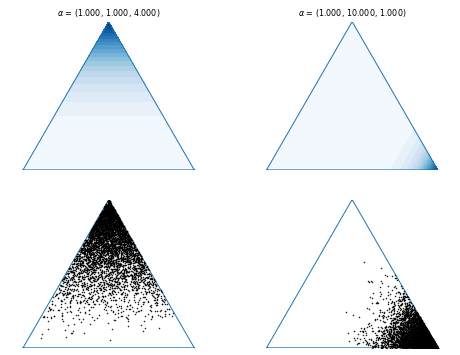

In [61]:
f = plt.figure(figsize=(8, 6))
alphas = [[1, 1, 4], [1, 10, 1]]
for (i, alpha) in enumerate(alphas):
    plt.subplot(2, len(alphas), i + 1)
    dist = Dirichlet(alpha)
    draw_pdf_contours(dist)
    title = r'$\alpha$ = (%.3f, %.3f, %.3f)' % tuple(alpha)
    plt.title(title, fontdict={'fontsize': 8})
    plt.subplot(2, len(alphas), i + 1 + len(alphas))
    plot_points(dist.sample(5000))
#plt.savefig('dirichlet_plots.png')
#print('Wrote plots to "dirichlet_plots.png".')